## Example of Making Predictions

This is basically a copy of the readability notebook.
You'll have to find your own way here!
The original readability random forest classifier is here and this code does at least read the right file.

If you want to proceed, brave adventurer, then make sure to read the [description of the data](https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/data).
The metrics you are trying to predict are only described as measures of engagement.

Remember to check the [kaggle discussion](https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/discussion) and [kaggle code](https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/code) for inspiration.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

from src.paths import DATA_PARQUET_TRAIN, DATA_PARQUET_TEST

In [2]:
df = pd.read_parquet(DATA_PARQUET_TRAIN)

In [3]:
df.target.astype(int).unique()

array([ 0, -1, -3, -2,  1])

---

### Random Forest Classifier

Here we train a random forest classifier on 5 folds.
The text is converted to features by using a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).
This produces a count for each distinct token after performing some basic preprocessing (lower case, strip accents).

In [4]:
%%time

kf = KFold()

vectorizer = CountVectorizer()
vectorizer.fit(df.excerpt)

forests = []
predictions = []

for train_indices, test_indices in kf.split(df):
    train_df = df.iloc[train_indices].copy()
    test_df = df.iloc[test_indices].copy()

    train_array = vectorizer.transform(train_df.excerpt).toarray()

    rf = RandomForestClassifier(max_features=1_000, oob_score=True)
    rf.fit(
        train_array,
        train_df.target.astype(int)
    )

    test_array = vectorizer.transform(test_df.excerpt).toarray()
    test_df["prediction"] = rf.predict(test_array)

    forests.append(rf)
    predictions.append(test_df[["target", "prediction"]])

CPU times: user 1min 15s, sys: 3.32 s, total: 1min 18s
Wall time: 1min 18s


---

### Random Forest Results

Now that it's trained we can see how well it performs.

In [5]:
all_predictions = pd.concat(predictions)

print(classification_report(
    all_predictions.target.astype(int),
    all_predictions.prediction,
    zero_division=0
))

              precision    recall  f1-score   support

          -3       0.00      0.00      0.00        75
          -2       0.37      0.05      0.08       421
          -1       0.40      0.27      0.32       835
           0       0.60      0.91      0.72      1447
           1       0.00      0.00      0.00        56

    accuracy                           0.55      2834
   macro avg       0.27      0.25      0.23      2834
weighted avg       0.48      0.55      0.48      2834



This plots the confusion matrix of the predictions.
This block of code is a hacked around version of something that Katie and Chloe came up with.
Thank you.

In [6]:
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np

def plotly_confusion_matrix(df: pd.DataFrame):
    df = df.copy()
    df["target"] = df.target.astype(int)
    
    labels = [-3, -2, -1, 0, 1]
    test_labels = df["target"].tolist()
    pred_labels = df["prediction"].tolist()
    
    # make everything but the diagonal negative to mark the wrong values as incorrect
    matrix = confusion_matrix(df["target"], df["prediction"], normalize="true")
    correct_incorrect_multiplicand = np.ones(matrix.shape)
    correct_incorrect_multiplicand *= -1
    np.fill_diagonal(correct_incorrect_multiplicand, 1)
    
    matrix = matrix * correct_incorrect_multiplicand
    
    fig = ff.create_annotated_heatmap(
        z=matrix,
        x=[str(f"{label} (n = {pred_labels.count(label)})") for label in labels],
        y=[str(f"{label} (n = {test_labels.count(label)})") for label in labels],
        colorscale=["red", "white", "green"],
        annotation_text=confusion_matrix(df["target"], df["prediction"]),
        zmin=-1,
        zmax=1,
        showscale=True,
        colorbar=dict(
            tickvals=[-1, 1],
            ticktext=['0% Correct Labels', '100% Correct Labels']
        )
    )
    fig.update_layout(
        title_text=f"True vs. Predicted Readability",
        title_x=0.5,
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Predicted Readability')),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='True Readability'))
    )
    return fig

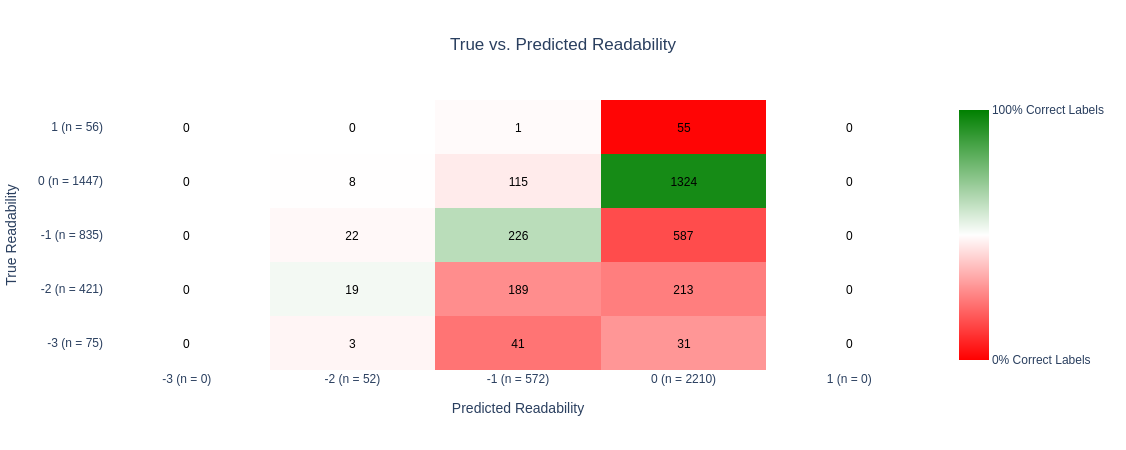

In [7]:
plotly_confusion_matrix(all_predictions)

Finally we can run the competition evaluation against these predictions to see what score we would get.

In [8]:
((all_predictions.target - all_predictions.prediction) ** 2).mean() ** 0.5

1.1949974834136678

**REMEMBER THIS IS THE READABILITY CODE**

---

### Submission

The submission for this competition is more involved.
It requires that you use the `mlb` package, which was provided in the downloaded data.
This package ensures that you do not peek at the future.
There is [example code]() for making a submission:

```python
import mlb
env = mlb.make_env() # initialize the environment
iter_test = env.iter_test() # iterator which loops over each date in test set

for (test_df, sample_prediction_df) in iter_test:
    sample_prediction_df['target1'] = 100 #make predictions here
    env.predict(sample_prediction_df)
```

I'm not making a submission here as I haven't even trained a model.
If you want to import mlb from the `data/raw/` folder then run this:

In [1]:
from src.paths import DATA_RAW_FOLDER
import sys
sys.path.append(str(DATA_RAW_FOLDER))

import mlb

ModuleNotFoundError: No module named 'mlb.competition'

As you can see this doesn't work right now.
There is a compiled binary `.so` file in that folder which contains the actual library.
You could try to get that working - or just use a kaggle notebook, which you will have to do anyway.